In [16]:
import numpy as np
import matplotlib.pyplot as plt
import shapely
import geojson
import planetary_computer
import pyproj
from pyproj import CRS
from pystac_client.client import Client
import shapely.wkt
import rasterio
from rasterio import features, warp, windows
from rasterio.mask import mask
from shapely.geometry import Point, Polygon, shape, MultiPolygon
from numpy import (
    nan as np_nan,
    ndarray,
    uint16 as np_uint16,
    errstate as np_errstate,
    where as np_where,
    iinfo as np_iinfo,
)

In [17]:
DECIMAL_SCALE = 0.0001
ZERO_DIVISOR_FIX = np_iinfo(np_uint16).max * 2
CONST_EVI_G = 2.5
CONST_EVI_C1 = 6.0
CONST_EVI_C2 = 7.5
CONST_EVI_L = 1

In [18]:
def apply_filters(index: ndarray) -> ndarray:
    """
    Apply filters to a NumPy array by modifying its values based on specific conditions.

    Parameters:
    -----------
    index : ndarray
        A NumPy array containing the data to be filtered.

    Returns:
    --------
    ndarray
        The filtered NumPy array with the following transformations:
    """
    index[index > 1] = 1.0
    index[index < -1] = -1.0
    index[index == 0] = np_nan
    return index



def calc_evi(
    b_nir: ndarray,
    b_red: ndarray,
    b_blue: ndarray,
    scalar_g: float = CONST_EVI_G,
    scalar_c1: float = CONST_EVI_C1,
    scalar_c2: float = CONST_EVI_C2,
    scalar_l: float = CONST_EVI_L,
) -> ndarray:
    """
    Calculate the Enhanced Vegetation Index (EVI) for arrays of reflectance values.

    EVI is a measure of vegetation health and density, improved for dense vegetation by correcting
    atmospheric effects and soil brightness. It is calculated using the formula:
    EVI = G * ((NIR - RED) / (NIR + C1 * RED - C2 * BLUE ) + L)

    Parameters:
    nir (np.ndarray): An array of reflectance values in the near-infrared band.
    red (np.ndarray): An array of reflectance values in the red band.
    blue (np.ndarray): An array of reflectance values in the blue band.
    g (float): Gain factor, default is 2.5.
    c1 (float): Coefficient for red band aerosol resistance, default is 6.0.
    c2 (float): Coefficient for blue band aerosol resistance, default is 7.5.
    l (float): Canopy background adjustment factor, default is 1.0.

    Returns:
    np.ndarray: An array of EVI values, typically ranging from -1 to 1.
    """
    b_nir = b_nir.astype(float) * DECIMAL_SCALE
    b_red = b_red.astype(float) * DECIMAL_SCALE
    b_blue = b_blue.astype(float) * DECIMAL_SCALE

    numerator = b_nir - b_red
    denominator = b_nir + (scalar_c1 * b_red) - (scalar_c2 * b_blue) + scalar_l

    with np_errstate(divide="ignore", invalid="ignore"):
        evi = np_where(denominator != 0, scalar_g * (numerator / denominator), 0)

    return apply_filters(evi)

In [28]:
def get_items(geojson_geometry):
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=geojson_geometry,
        datetime="2023-01-01/2023-01-05",
        limit=1  # Ajuste conforme necessário
    )
    items = list(search.get_items())
    
    return items

In [20]:
def generate_geojson(wkt):
    geometry = shapely.wkt.loads(wkt)
    geojson_geometry = shapely.geometry.mapping(geometry)

    return geojson_geometry

def get_band_info(href, area):
    shapely_geometry = shape(area)
    with rasterio.open(href) as ds:
        warped_geometry = warp.transform_geom(
            "EPSG:4326", ds.crs, shapely_geometry
        )
        _, out_transform = mask(ds, [warped_geometry], crop=True)

        return {
            "transform": out_transform, #transformação do recorte
            "crs": int(f"{ds.crs}".split(":")[1]), #epsg do raster
        }

def raster(href, wkt):
    shapely_geometry = shape(wkt) #Transforma uma geometria WKT (wkt) em uma geometria Shapely
    with rasterio.open(href) as ds: #bre um arquivo raster (href)
        warped_geometry = warp.transform_geom(
            "EPSG:4326", ds.crs, shapely_geometry    #Transforma a geometria para a mesma projeção do raster
        )
        out_image, _ = mask(ds, [warped_geometry], crop=True) #Aplica uma máscara ao raster com a geometria transformada

    return out_image

In [24]:
def generate_images_evi(items, wkt):
    for image in items:
        band_red_href = image.assets['B04'].href
        band_nir_href = image.assets['B08'].href
        band_green_href = image.assets['B03'].href
        band_blue_href = image.assets['B02'].href
        band_scl = image.assets['SCL'].href
        print('entrei')
        band_info = get_band_info(band_red_href, wkt)
        
        
        bands = {'band_red': raster(band_red_href, wkt)[0],
                 'band_nir': raster(band_nir_href, wkt)[0],
                 'band_green': raster(band_green_href, wkt)[0],
                 'band_blue': raster(band_blue_href, wkt)[0],
                 'band_scl': raster(band_scl, wkt)[0],
                 'transform': band_info["transform"],
                 'crs': band_info["crs"]}
        
        evi_img = calc_evi(bands['band_nir'], bands['band_red'], bands['band_blue']) #calculo EVI usando Numpy NP
        img_matriz = evi_img.astype("float64")
        
        new_crs = CRS.from_epsg(bands["crs"]) #projeção do sentinel
        transform = bands["transform"]
        
        print(new_crs)
        
        with rasterio.open(
            'C:\\Users\\renan.granusso\\Desktop\\Teste\\rasters\\sentinel_img_evi2.tif', 'w',
            driver="GTiff",
            width=img_matriz.shape[1],
            height=img_matriz.shape[0],
            count=1,
            dtype=img_matriz.dtype,
            crs=new_crs,
            transform=transform
        ) as dst:
            dst.write(img_matriz, 1)
            
    return new_crs

entrei
EPSG:32723
entrei
EPSG:32722


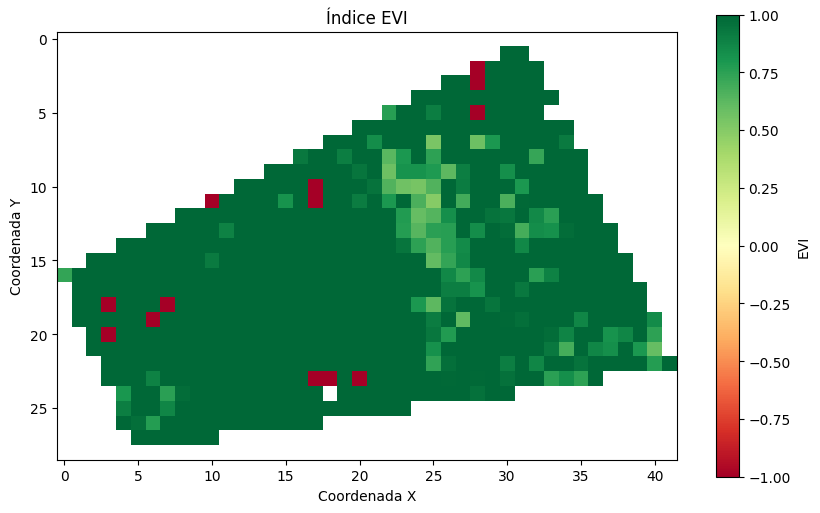

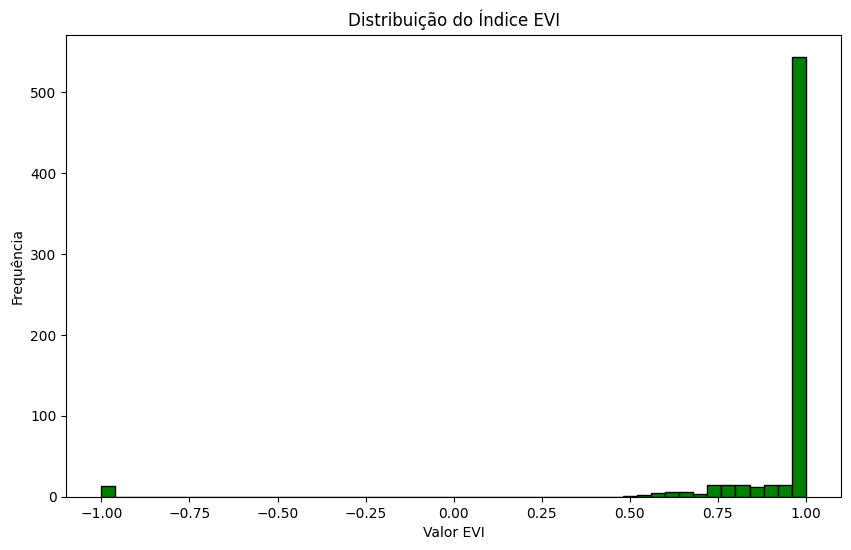

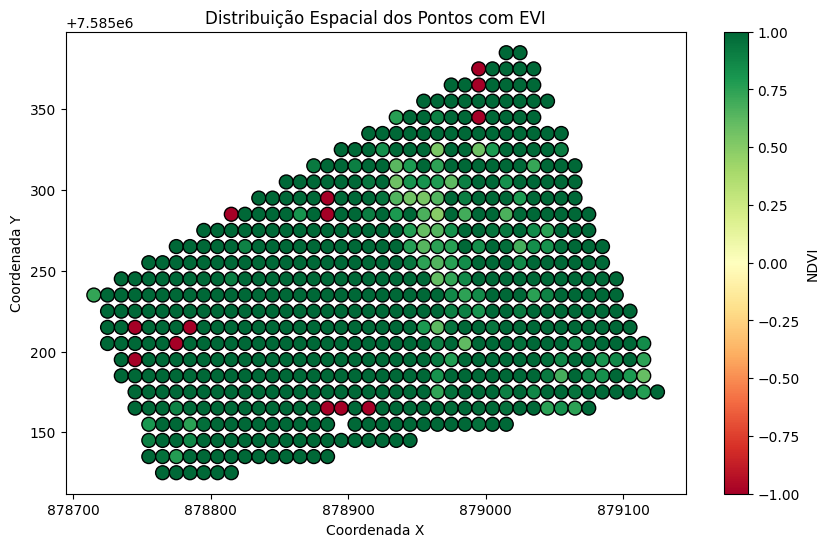

In [32]:
wkt = "Polygon ((-47.33807993498817268 -21.79619163711584662, -47.3350509751772961 -21.79465868794327221, -47.33403516548462164 -21.79665336879433468, -47.33756279550826207 -21.79724438534279685, -47.33807993498817268 -21.79619163711584662))"
epsg = 4326

area = generate_geojson(wkt)
items = get_items(area)

crs = generate_images_evi(items, area) #gera imagens .tif

#Plotar os pontos em um gráfico

with rasterio.open('C:\\Users\\renan.granusso\\Desktop\\Teste\\rasters\\sentinel_img_evi2.tif') as src:
    # Leia a primeira banda (presumindo que o NDVI esteja na primeira banda)
    evi = src.read(1)

    # Filtrar valores nodata e valores irrelevantes
    ndvi = np.where((evi >= -1) & (evi <= 1), evi, np.nan)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label="EVI")
    plt.title("Índice EVI")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.show()
    
    # Histograma dos valores de NDVI
    plt.figure(figsize=(10, 6))
    plt.hist(ndvi[~np.isnan(evi)], bins=50, color='green', edgecolor='black')
    plt.title("Distribuição do Índice EVI")
    plt.xlabel("Valor EVI")
    plt.ylabel("Frequência")
    plt.show()
    
    # Exibir valor NDVI de cada ponto e imprimir apenas uma amostra
    evi = np.where((evi >= -1) & (evi <= 1), evi, np.nan)
    n_linhas, n_colunas = evi.shape
    
    points = []
    
    for linha in range(n_linhas):
        for coluna in range(n_colunas):
            valor_evi = evi[linha, coluna]
            if str(valor_evi) != 'nan':
                lon, lat = src.transform * (coluna + 0.5, linha + 0.5)
                point = {
                    "longitude": lon,
                    "latitude": lat,
                    "valor_evi": valor_evi
                }
                #print(point['valor_ndvi'])
                points.append(point)

    

x_coords = [lon['longitude'] for lon in points]
y_coords = [lat['latitude'] for lat in points]
ndvi_values = [ndvi['valor_evi'] for ndvi in points]

plt.figure(figsize=(10, 6)) #define o tamanho da imagem

scatter = plt.scatter(x_coords, y_coords, c=ndvi_values, cmap='RdYlGn', s=100, edgecolor='k', vmin=-1, vmax=1)

plt.colorbar(scatter, label="NDVI")  # Barra de cor indicando valores NDVI

# Títulos e legendas
plt.title("Distribuição Espacial dos Pontos com EVI")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")

plt.show()